# RETREAT workflow by UTM zone

In [2]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pystac
import stackstac
import xarray as xr
import pandas as pd

## Utility functions

In [3]:
def check_orig_files(item):
    
    file_ls = ['orig_file_dis_az', 'orig_file_dis_mag','orig_file_dis_N_ang','orig_file_dis_r']
    
    dt_ls, ref_date_ls, sec_date_ls = [],[],[]
    for file in file_ls:
        
        var_name_dt = f'{file}_datetime'
        var_name_ref = f'{file}_ref_date'
        var_name_sec = f'{file}_sec_date'
        
        var_name_dt = item.extra_fields[file][22:30]
        var_name_ref = item.extra_fields[file].split('+S1_')[1][:15]
        var_name_sec = item.extra_fields[file].split('+S1_')[1].split('_')[9]
        
        dt_ls.append(var_name_dt)
        ref_date_ls.append(var_name_ref)
        sec_date_ls.append(var_name_sec)
       
    if len(set(dt_ls)) != 1:
           print('issue w dt')
    elif len(set(ref_date_ls)) != 1:
             print('issue with ref date')
             
    elif len(set(sec_date_ls)) != 1:
             print('issue w sec date')

## RGI

In [4]:
rgi_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/rgi/'

In [5]:
rgi15 = gpd.read_file(os.path.join(rgi_path, 'rgi15', '15_rgi60_SouthAsiaEast.shp'))
rgi14 = gpd.read_file(os.path.join(rgi_path, 'rgi14', '14_rgi60_SouthAsiaWest.shp'))
rgi13 = gpd.read_file(os.path.join(rgi_path, 'rgi13', '13_rgi60_CentralAsia.shp'))

In [6]:
rgi= pd.concat([rgi13,rgi14,rgi15])

## UTM grids

In [7]:
utm_dir = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/utm/'

In [8]:
utm_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/utm/World_UTM_Grid(1).geojson'

In [9]:
utm = gpd.read_file(utm_path)

In [10]:
utm_hma = gpd.sjoin(utm, rgi, how='inner')

In [11]:
utm_hma = utm_hma.iloc[:,:7].drop_duplicates()
utm_hma.head()

,FID,ZONE,ROW_,WEST_VALUE,CM_VALUE,EAST_VALUE,geometry
380,381,43,R,72E,75E,78E,"POLYGON ((72.00000 32.00000, 73.00000 32.00000..."
874,875,43,S,72E,75E,78E,"POLYGON ((72.00000 40.00000, 73.00000 40.00000..."
382,383,44,R,78E,81E,84E,"POLYGON ((84.00000 32.00000, 84.00000 31.00000..."
386,387,45,R,84E,87E,90E,"POLYGON ((90.00000 32.00000, 90.00000 31.00000..."
877,878,44,S,78E,81E,84E,"POLYGON ((78.00000 40.00000, 79.00000 40.00000..."


In [12]:
utm42 = utm_hma.loc[utm_hma['ZONE'] == 42]
utm43 = utm_hma.loc[utm_hma['ZONE'] == 43]
utm44 = utm_hma.loc[utm_hma['ZONE'] == 44]
utm45 = utm_hma.loc[utm_hma['ZONE'] == 45]
utm46 = utm_hma.loc[utm_hma['ZONE'] == 46]
utm47 = utm_hma.loc[utm_hma['ZONE'] == 47]


In [13]:
utm_ls = [utm42, utm43, utm44, utm45, utm46, utm47]

In [14]:
utm_all = pd.concat(utm_ls)

In [15]:
utm42.bounds

,minx,miny,maxx,maxy
871,66.0,32.0,72.0,40.0


<AxesSubplot: >

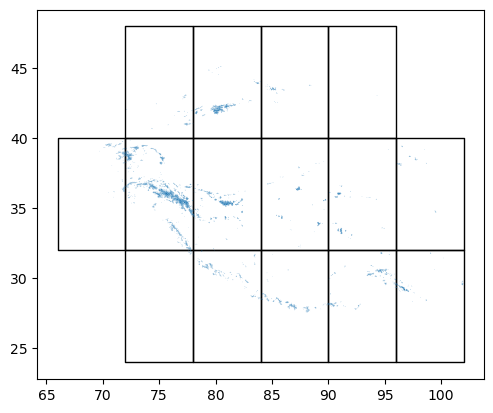

In [16]:
fig, ax = plt.subplots()
utm_hma.plot(facecolor='None', ax=ax)
rgi.plot(ax=ax)

### Divide RGI by UTM zone

In [17]:
utm_ls[0]['ZONE'].values[0]

42

In [18]:
def subset_rgi_by_utm(rgi_df, utm_df, zone):

        utm_zone = utm_df.loc[utm_df['ZONE'] == zone]
                              
        rgi_zone = gpd.sjoin(rgi_df, utm_zone, how='inner')

        return rgi_zone


In [19]:
rgi_utm42 = subset_rgi_by_utm(rgi, utm_all, 42)
rgi_utm43 = subset_rgi_by_utm(rgi, utm_all, 43)
rgi_utm44 = subset_rgi_by_utm(rgi, utm_all, 44)
rgi_utm45 = subset_rgi_by_utm(rgi, utm_all, 45)
rgi_utm46 = subset_rgi_by_utm(rgi, utm_all, 46)
rgi_utm47 = subset_rgi_by_utm(rgi, utm_all, 47)

## RETREAT data from STAC Catalog

In [20]:
catalog = pystac.Catalog.from_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/stac_catalog/catalog.json')


In [21]:
items = list(catalog.get_all_items())

In [22]:
for item in items:
    
    check_orig_files(item)

In [23]:
feature_coll = [item.to_dict() for item in items]

In [24]:
stac_gdf = gpd.GeoDataFrame.from_features(feature_coll)

In [25]:
stac_gdf = stac_gdf.set_crs('EPSG:4326')

In [26]:
len(gpd.sjoin(stac_gdf, utm44))

314

In [27]:
utm_strs = ['42','43','44','45','46','47']

In [28]:
def subset_stac_items_to_utm(stac_gpdf, utm_ls, utm_strs):
    
    dd = []
    for item in range(len(utm_ls)):
                
        joined = gpd.sjoin(stac_gpdf, utm_ls[item])
        joined = joined.drop('index_right',axis=1)
        
        if len(joined) > 1:
            #print('The stac catalog has items that lie in this UTM zone')
            
            d = {utm_strs[item]:joined}
            dd.append(d)
        
        else:
            pass

    n = len(dd)
    print('Items in this catalog lie in : ', n, ' UTM zones.')
    
    if n == 2:
        z = {**dd[0], **dd[1]}
    if n == 3:
        z = {**dd[0], **dd[1],**dd[2]}
        
    print('They are zones: ', list(z.keys()))
        
    return z
            
            
    

In [29]:
i = subset_stac_items_to_utm(stac_gdf, utm_ls,utm_strs)

Items in this catalog lie in :  2  UTM zones.
They are zones:  ['44', '45']


<AxesSubplot: >

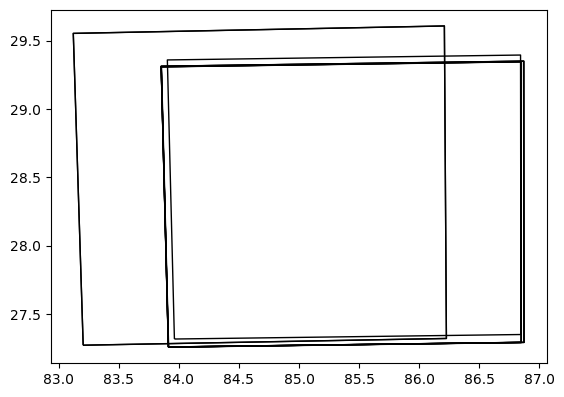

In [30]:
i['44'].iloc[0:10].plot(facecolor='None')

This currently returns a dict with the retreat scenes that lie in the specified UTM zone. is this what we want? 

<AxesSubplot: >

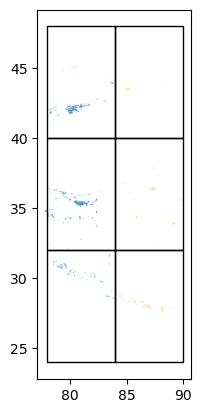

In [31]:
fig, ax = plt.subplots()
gpd.sjoin(rgi, utm44, how='inner').drop_duplicates().plot(ax=ax)

gpd.sjoin(rgi, utm45, how='inner').drop_duplicates().plot(ax=ax, color='orange', alpha = 0.5)

utm44.plot(ax=ax, facecolor='None')
utm45.plot(ax=ax, facecolor='None')

<AxesSubplot: >

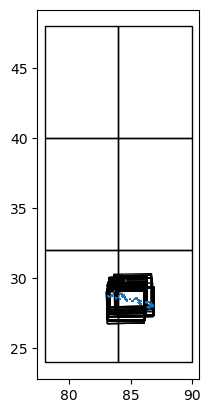

In [32]:
len(i)
i.keys()
fig, ax = plt.subplots()

i['44'].plot(facecolor='None', ax=ax)
utm44.plot(facecolor='None', ax=ax)
utm45.plot(facecolor='None', ax=ax)
gpd.sjoin(rgi, i['44'], how='inner').drop('index_right',axis=1).plot(ax=ax)

<AxesSubplot: >

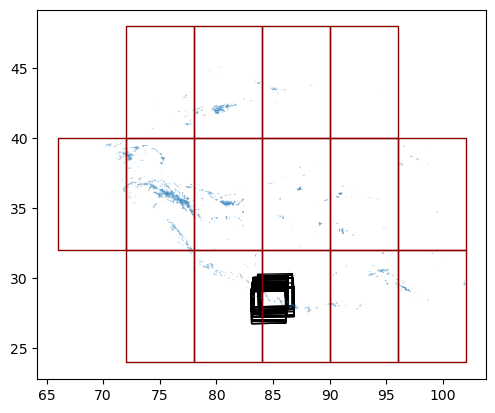

In [33]:
fig, ax = plt.subplots()
stac_gdf.plot(facecolor='None', ax=ax)
rgi.plot(ax=ax)
utm_hma.plot(ax=ax, facecolor='None', edgecolor = 'darkred')



## Now start ind glacier workflow from single glacier stackstac?

In [1]:
catalog

NameError: name 'catalog' is not defined